The idea of adversarial autoencoder (AAE) is similar to variational autoencoder (VAE), which is to force the latent space to match a prior distribution. They use different strategies, VAE imposes a KL divergence term on the loss function, while AAE utilizes generative adversarial training to make the latent space converge to a prior.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import math
from utils.gaussian_mixture import Gaussian_mixture

Read MNIST dataset

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../Bayesian-learning/datasets/MNIST_data', one_hot=False)
num_train_samples = mnist.train.num_examples
num_valid_samples = mnist.validation.num_examples
num_test_samples = mnist.test.num_examples

print("Number of training samples: %d" % num_train_samples)
print("Number of validation samples: %d" % num_valid_samples)
print("Number of test samples: %d" % num_test_samples)

Extracting ../Bayesian-learning/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../Bayesian-learning/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../Bayesian-learning/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../Bayesian-learning/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz
Number of training samples: 55000
Number of validation samples: 5000
Number of test samples: 10000


Define an encoder which encodes images into latent vectors

In [3]:
def encoder(x, layer_units, latent_dim, activation_fn=tf.nn.relu):
    """
    x: the input.
    layer_units: for example, [500, 300] means two layers, one has 500 nodes, another has 300 nodes.
    latent_dim: dimension of latent space.
    """
    with tf.variable_scope("encoder"):
        input_tensor = x
        for i in layer_units:
            output_tensor = tf.contrib.layers.fully_connected(input_tensor, i, activation_fn=activation_fn)
            '''
            normalized = tf.contrib.layers.batch_norm(output_tensor, center=True, scale=True, 
                                                      is_training=is_training)
            '''
            input_tensor = output_tensor
    
        z = tf.contrib.layers.fully_connected(output_tensor, latent_dim, activation_fn=None)
    return z

Define a decoder which decodes latent vectors to reconstruct images

In [4]:
def decoder(z, layer_units, output_dim, activation_fn=tf.nn.relu):
    """
    z: the latent variables.
    layer_units: for example, [300, 500].
    ouput_dim: dimension of output, identical to input x.
    """  
    with tf.variable_scope("decoder"):    
        input_tensor = z
        for i in layer_units:
            output_tensor = tf.contrib.layers.fully_connected(input_tensor, i, activation_fn=activation_fn)
            input_tensor = output_tensor
    
        # Output Bernoullis since the original picture is gray scaled.
        x_hat = tf.contrib.layers.fully_connected(output_tensor, output_dim, activation_fn=tf.sigmoid)
    return x_hat

In [5]:
def discriminator(samples, layer_units, activation_fn=tf.nn.relu, reuse=None):
    
    with tf.variable_scope("discriminator", reuse=reuse): 
        input_tensor = samples
        for i in layer_units:
            output_tensor = tf.contrib.layers.fully_connected(input_tensor, i, activation_fn=activation_fn)
            input_tensor = output_tensor
    
        # Outputs are the probability that samples are true.
        probs = tf.contrib.layers.fully_connected(output_tensor, 1, activation_fn=tf.sigmoid)
    return probs

Set hyper-parameters

In [6]:
batch_size = 100

input_dim = 784
latent_dim = 2

encoder_layer_units = [1000, 1000]
decoder_layer_units = [1000, 1000]
discriminator_layer_units = [1000, 1000]

output_dim = 784

In [7]:
X = tf.placeholder(tf.float32, shape = [None, input_dim])

# Deterministic encoding
z = encoder(X, layer_units=encoder_layer_units, latent_dim=latent_dim)

# Reconstruct input X
X_hat = decoder(z, layer_units=decoder_layer_units, output_dim=output_dim)

# The reconstruction loss
reconstruction_loss = tf.reduce_mean(-tf.reduce_sum(X * tf.log(1e-16 + X_hat) + (1 - X) * tf.log(1e-10 + 1 - X_hat), 1))

# Sample z_hat from a Gaussian mixture, the same model as 7. Mixture of Gaussians.ipynb
latent_dist = Gaussian_mixture(theta=0., phi=0.2 * math.pi, r=5., initial_cov=[[2.5, 0.], [0., 0.04]], num_gaussians=10)
z_hat = latent_dist.get_samples(batch_size)

# Real and fake probs
real_probs = discriminator(z_hat, layer_units=discriminator_layer_units)
fake_probs = discriminator(z, layer_units=discriminator_layer_units, reuse=True)

# The discriminator aims to distinguish z and z_hat
discriminator_value = tf.reduce_mean(tf.log(1e-10 + real_probs) + tf.log(1e-10 + 1 - fake_probs))

# The encoder aims to fool the discriminator.
encoder_value = tf.reduce_mean(tf.log(1e-10 + 1 - fake_probs))

# Separate trainable parameters
encoder_parameters = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='encoder')
decoder_parameters = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='decoder')
discriminator_parameters = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')

# Training consists of two parts, first update the autoencoder then train generative adversarial nets (two separate training phase).
reconstruction_optimizer = tf.train.AdamOptimizer(0.001).minimize(reconstruction_loss, var_list=[encoder_parameters, 
                                                                                                decoder_parameters])

discriminator_optimizer = tf.train.AdamOptimizer(0.001).minimize(-discriminator_value, var_list=discriminator_parameters)

encoder_optimizer = tf.train.AdamOptimizer(0.001).minimize(encoder_value, var_list=encoder_parameters)

In [12]:
training_times = 10001
sess = tf.Session()
sess.run(tf.global_variables_initializer())

re_average_loss = 0
dis_average_loss = 0
en_average_loss = 0
for i in range(training_times):
    xs, _ = mnist.train.next_batch(batch_size)
    
    # Train the autoencoder
    _, re_loss_val = sess.run([reconstruction_optimizer, reconstruction_loss], feed_dict={X: xs})
    
    # Train the discriminator 
    _, dis_loss_val = sess.run([discriminator_optimizer, discriminator_value], feed_dict={X: xs})
    
    # Train the encoder
    _, en_loss_val = sess.run([encoder_optimizer, encoder_value], feed_dict={X: xs})
    
    re_average_loss += re_loss_val
    #dis_average_loss += dis_loss_val
    #en_average_loss += en_loss_val
    
    if i % 1000 == 0:
        if i == 0:
            print("Global step %d, reconstruction loss: %.2f; discriminator value: %.2f; encoder value: %.2f" % 
                              (i, re_average_loss, -dis_loss_val, en_loss_val))
        else:
            print("Global step %d, reconstruction loss: %.2f; discriminator value: %.2f; encoder value: %.2f" % 
                              (i, re_average_loss / 1000, -dis_loss_val, en_loss_val))
        re_average_loss = 0
        #dis_average_loss = 0
        #en_average_loss = 0
        

Global step 0, reconstruction loss: 543.36; discriminator value: 1.37; encoder value: -0.64
Global step 1000, reconstruction loss: 171.01; discriminator value: 1.32; encoder value: -0.66
Global step 2000, reconstruction loss: 163.84; discriminator value: 1.21; encoder value: -0.54
Global step 3000, reconstruction loss: 156.94; discriminator value: 1.19; encoder value: -0.59
Global step 4000, reconstruction loss: 151.26; discriminator value: 1.18; encoder value: -0.61
Global step 5000, reconstruction loss: 147.37; discriminator value: 1.10; encoder value: -0.60
Global step 6000, reconstruction loss: 146.04; discriminator value: 1.14; encoder value: -0.64
Global step 7000, reconstruction loss: 145.15; discriminator value: 1.24; encoder value: -0.67
Global step 8000, reconstruction loss: 144.68; discriminator value: 1.24; encoder value: -0.66
Global step 9000, reconstruction loss: 144.59; discriminator value: 1.09; encoder value: -0.53
Global step 10000, reconstruction loss: 144.42; discr

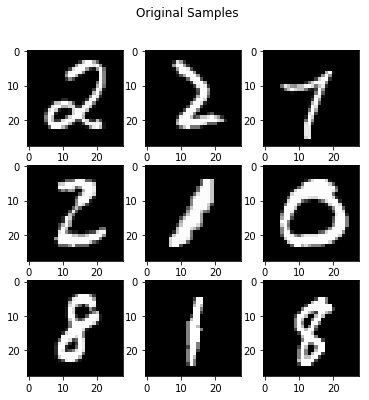

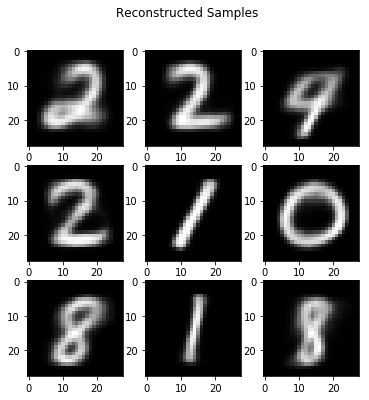

In [13]:
x_sample = mnist.train.next_batch(100)[0]
x_reconstructed = sess.run(X_hat, feed_dict={X:x_sample})
    
ori_samples = x_sample[:9]
plt.figure(figsize=(6, 6))
plt.suptitle("Original Samples")
for i, image in enumerate(ori_samples):
    plt.subplot(3, 3, i+1)
    plt.imshow(image.reshape(28, 28), cmap="gray")
plt.show()

re_samples = x_reconstructed[:9]
plt.figure(figsize=(6, 6))
plt.suptitle("Reconstructed Samples")
for i, image in enumerate(re_samples):
    plt.subplot(3, 3, i+1)
    plt.imshow(image.reshape(28, 28), cmap="gray")
plt.show()

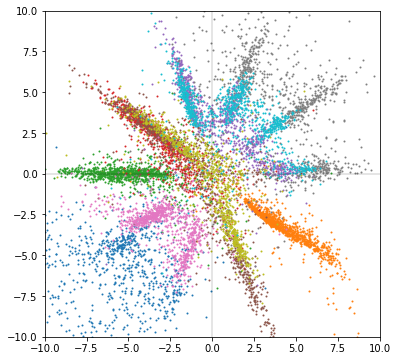

In [14]:
test_samples = mnist.test
test_images = [[] for i in range(10)]
for i in range(num_test_samples):
    test_images[mnist.test.labels[i]].append(mnist.test.images[i])
    
latent_codes =  [[] for i in range(10)]
for i in range(10):
    x_samples = test_images[i]
    latent_codes[i].extend(sess.run(z, feed_dict={X:x_samples}))

import numpy as np
latent_codes = np.asarray(latent_codes)

for i in range(10): 
    latent_codes[i] = np.asarray(latent_codes[i]).reshape(len(latent_codes[i]), 2)

plt.figure(figsize=(6, 6))
for i in range(10):
    plt.scatter(latent_codes[i][:, 0], latent_codes[i][:, 1], s=1.)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.axhline(y=0, color='k', linewidth=0.2)
plt.axvline(x=0, color='k', linewidth=0.2)
plt.show()

This is an unsupervised setting, one Gaussian model from the mixture may include multiple labels but anyway we can see images with different labels are separated indeed.